#### [2022-1 텍스트분석기법]

# Individual Assignment 1 샘플 코드  
학습 데이터셋을 기준으로 분석 과정을 보여줍니다.   
테스트 데이터셋이나 전체 데이터셋에 대한 분석은 이를 비슷하게 적용하시면 되겠습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hanspell import spell_checker
from tqdm import tqdm
from konlpy.tag import Okt
from wordcloud import WordCloud
from matplotlib import font_manager, rc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1. 데이터 탐색

#### 1.1 데이터 불러오기

In [2]:
train_data = pd.read_table('../Data/ratings_train.txt', delimiter = '\t')
test_data = pd.read_table('../Data/ratings_test.txt', delimiter = '\t')

# train_data = pd.read_csv('./Data/ratings_train.txt', sep='\t')
# test_data = pd.read_csve('./Data/ratings_test.txt', sep='\t')

# data = pd.read_table('../Data/naver_movie_reviews_utf8.txt', delimiter = '\t')
# data = pd.read_csve('./Data/naver_movie_reviews_utf8.txt', sep='\t')

print(len(train_data), len(test_data))

150000 50000


#### 1.2 데이터 살펴보기

In [3]:
train_data.columns

Index(['id', 'document', 'label'], dtype='object')

In [4]:
train_data.shape

(150000, 3)

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
train_data.label.value_counts()   # label 칼럼 분포 확인 

0    75173
1    74827
Name: label, dtype: int64

#### 1.3 데이터 타입/개수 확인, 결측치 처리, 중복 데이터 확인 하기

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [8]:
# 결측치가 있는 행 제거
train_df = train_data.dropna()  # 디폴트 axis = 0 : 행 제거
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [9]:
# 중복 데이터 확인
train_df['document'].nunique(), train_df['label'].nunique() 

# 146182 < 149995  => 중복 내용 확인 필요

(146182, 2)

In [10]:
# 중복 데이터 확인
train_df[train_df.duplicated(['document'], keep=False)].sort_values(by='document')[:30] 
# keep=False로 하면 'document' 내용이 서로 중복되는 행은 모두 True 

# 같은 내용인데 라벨이 서로 다른 것들도 있음

,id,document,label
114089,6993402,!,0
20014,181912,!,1
28313,787891,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
13624,787889,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
123606,7868198,",",1
139045,7448690,",",1
18327,7481337,",,,",0
48954,2853697,",,,",1
55020,7935083,",,,",0
117079,6868999,",,,",0


In [11]:
# 중복 데이터 확인
train_df[train_df.duplicated(['document'], keep=False)].sort_values(by='document')[-30:] 

# 충분히 긴 내용이어도 같은 내용인데 라벨이 서로 다른 것들도 있음

,id,document,label
127095,3843661,헐,0
43076,7030456,헐,0
41984,7546205,헐....,0
124079,4759568,헐....,0
52284,9488714,홍진호가 최고여야 하고 홍진호만 우승해야 한다고 주장하는 콩빠들 극혐;;,1
6064,9488717,홍진호가 최고여야 하고 홍진호만 우승해야 한다고 주장하는 콩빠들 극혐;;,0
46442,3301015,화이팅,1
25064,6211444,화이팅,0
68813,6126339,화이팅,1
113245,6694123,홧팅,1


### 2. 데이터 전처리   

**텍스트 전처리 방향을 결정하기 위해 먼저 Okt 형태소분석기 작동 방식 관찰**   
감성에 영향을 미칠 것으로 판단되는 '!!!!!', ';;', '....' 가 앞 단어와 떨어져있지 않아도 그대로 토큰화됨   
&rightarrow; 이것들은 따로 띄어쓰기 전처리를 할 필요는 없어보임 

In [12]:
import pandas as pd
from konlpy.tag import Okt
okt = Okt()

sample_df = pd.DataFrame({"document":["힐러리 더프의 매력에 빠지다!!!!!", 
                                    "황진호만 우승해야 한다고 주장하는 콩빠들 극혐;;", 
                                    "헐...."]})

X_test = []
for sentence in sample_df['document']:
#     X_test.append(okt.pos(sentence))
    X_test.append(okt.morphs(sentence))
    
X_test

[['힐러리', '더프', '의', '매력', '에', '빠지다', '!!!!!'],
 ['황진호', '만', '우승해야', '한다고', '주장', '하는', '콩빠들', '극혐', ';;'],
 ['헐', '....']]

**데이터 탐색 결과에 기반한 데이터 전처리 방향**

- 벤치마크 데이터셋이라 일단 중복 데이터나 라벨이 서로 다른 부분은 유지하기로 결정
- 마침표 1개로 이루어진 리뷰에 대한 라벨이 서로 다른 것들도 있고, 이 외에 글자 수가 하나인 리뷰는 의미를 판단하기 어려워보이므로 삭제를 고려함. 그런데 '굳', '굿', '헐' 등이 함께 제외되는 문제가 있어 마침표나 기호문자 1개로 이루어진 리뷰만 삭제하기로 함
- 기호문자 반복 패턴 중 ; . ! ? 4개 이상 반복되는 것들은 3개로 변환하기로 결정 
- 이 외에 ㄱ-ㅎㅏ-ㅣ가-힣!.;? 아닌 것들은 삭제하기로 결정

In [1]:
# 필요한 전처리 코드 확인
import re
text = "힐러리???? ..... ;;;; 매력에 빠지다!!!!!"
re.sub(r"([!;.?]){4,}", r'\1'*3, text)   #  ; . ! ? 4개 이상 반복되는 것들은 3개로 변환

'힐러리??? ... ;;; 매력에 빠지다!!!'

In [14]:
# 필요한 전처리 코드 확인
text = "힐러리    매력에 빠지다"
re.sub('[\s]{2,}', " ", text)  # 공백 2개 이상은 하나로 변환 

'힐러리 매력에 빠지다'

In [15]:
# 필요한 전처리 코드 확인
sample_df['document'].str.replace(r"([!;.?]){4,}", r'\1'*3, regex=True)

0             힐러리 더프의 매력에 빠지다!!!
1    황진호만 우승해야 한다고 주장하는 콩빠들 극혐;;
2                           헐...
Name: document, dtype: object

#### 2.1 데이터 정제 - 노이즈 제거

In [16]:
# 한글  ; . ! ? 공백이 아닌 것들은 모두 공백으로 변환 (경우에 따라 그냥 제거할 수도 있음)
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;.!? ]"," ") 

# 공백 2개 이상은 하나로 변환 
train_df['document'] = train_df['document'].str.replace('[\s]{2,}', " ") 
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [17]:
# 마침표 하나로 이루어진 리뷰 갯수 확인
len(train_df[train_df['document']=="."])

49

In [18]:
# 마침표 하나로 이루어진 리뷰는 ""로 변환
train_df.loc[train_df['document']==".", "document"] = ""

# 마침표 하나로 이루어진 리뷰 처리가 제대로 되었는지 확인
print(len(train_df[train_df['document']=="."]))

0


내용이 없는 "" 인 리뷰들이 생겼으므로 NaN 값으로 바꾼 후 dropna()로 제거

In [19]:
print(len(train_df))

# ""인 리뷰는 NaN 으로 변환 
train_df['document'].replace("", np.nan, inplace=True)

train_df.info()

149995
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149946 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [20]:
train_df = train_df.dropna(axis = 0) # 결측치가 있는 행 제거(axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149946 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149946 non-null  int64 
 1   document  149946 non-null  object
 2   label     149946 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


문장 부호 !;.? 4개 이상 반복 패턴 3개로 자르기

In [21]:
# !;.? 4개 이상 반복 패턴 3개로 자르기
train_df['document'] = train_df['document'].str.replace(r"([!;.?]){4,}", r'\1'*3, regex=True)

#### 2.2 데이터 정제 - 한글 띄어쓰기 및 맞춤법 교정

In [22]:
# 맞춤법 교정한 새로운 컬럼을 만들어 이전과 비교

train_df['document_sp_checked'] = ""

for i in tqdm(range(len(train_df))): 
    try: 
        spelled_train = spell_checker.check(train_df['document'][i]) 
        train_df['document_sp_checked'][i] = spelled_train.checked 
    except: 
        pass

100%|████████████████████████████████████████████████████████████████████████| 149946/149946 [3:08:26<00:00, 13.26it/s]


In [23]:
train_df.head()

,id,document,label,document_sp_checked
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙.. 진짜 짜증 나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄...오버연기조차 가볍지 않구나,1,흠... 포스터 보고 초등학생영화 줄... 오버 연기조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 .. 솔직히 재미는 없다.. 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이먼 페그의 익살스러운 연기가 돋보였던 영화! 스파이더맨에서 늙어 보이기만 했던 ...


In [24]:
# 맞춤법 교정에 시간이 오래 걸리므로 결과 파일 저장
train_df.to_csv('raitings_train_inc_spelled.csv', index = False)

#### 2.3 데이터 전처리 - 형태소 분석에 의한 토큰화와 정규화 및 불용어 제거

In [25]:
train_review = pd.read_csv('raitings_train_inc_spelled.csv')

- 불용어 리스트 정의하기

In [26]:
# 한국어 불용어 사전 이용(사용 예시를 보이기 위해 추가)
stopwords_csv = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

print(stopwords_csv[:5])

stopwords = [i[0] for i in stopwords_csv]

print(stopwords[:5])

# 불용어 리스트 필요시 추가
stopwords_list = ['으로', '하죠', '텐데']

# 불용어 리스트 합치기
stopwords = list(set(stopwords + stopwords_list))

print(stopwords[-20:])
print(len(stopwords))

[['휴'], ['아이구'], ['아이쿠'], ['아이고'], ['어']]
['휴', '아이구', '아이쿠', '아이고', '어']
['까지', '설령', '시각', '때문에', '이와 같은', '고로', '너희', '공동으로', '어떤', '로부터', '하게하다', '이천팔', '이것', '에 있다', '지말고', '저', '어기여차', '그래', '따지지 않다', '더군다나']
596


- 형태소 분석에 의한 토큰화와 정규화 및 불용어 제거

In [27]:
# 토크나이저 정의 
okt = Okt()

def my_tokenizer(doc):
    return [token for token, pos in okt.pos(doc, norm=True, stem=True) if pos in ['Noun', 'Verb', 'Adjective']]

# 문자 수 1개인 토큰 삭제시 아래 코드 적용 
#     return [token for token, pos in okt.pos(doc, norm=True, stem=True) if (pos in ['Noun', 'Verb', 'Adjective']) and (len(token) > 1)]

In [28]:
X_train = []
# for sentence in tqdm(train_review['document_sp_checked']):  # 맞춤법 교정한 리뷰 사용   
for sentence in tqdm(train_review['document']):    # 맞춤법 교정은 생략한 리뷰 사용
    tokenized_sentence = my_tokenizer(sentence)
    stopwords_removed = [word for word in tokenized_sentence if word not in stopwords]
    X_train.append(stopwords_removed)

100%|█████████████████████████████████████████████████████████████████████████| 149946/149946 [08:27<00:00, 295.73it/s]


In [29]:
train_token = pd.DataFrame({'id' : train_review['id'], 'X_train' : X_train, 'Y_train' : train_review['label']})
train_token.head()

,id,X_train,Y_train
0,9976970,"[더빙, 진짜, 짜증나다, 목소리]",0
1,3819312,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 가볍다, 않다]",1
2,10265843,"[무재, 밓었, 다그, 래서, 보다, 추천]",0
3,9045019,"[교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]",0
4,6483659,"[몬페, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 늙다, 보이다, 하다, ...",1


### 3. 키워드 분석

#### 3.1 리뷰 감성별 단어 빈도 확인

In [37]:
# 리뷰 감성별로 토큰 분류
token_pos = train_token.loc[train_token['Y_train']==1].X_train.values.tolist()
token_neg = train_token.loc[train_token['Y_train']==0].X_train.values.tolist()

print(token_pos[:10])

[['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍다', '않다'], ['몬페', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '늙다', '보이다', '하다', '커스틴', '던스트', '이쁘다', '보이다'], ['액션', '없다', '재미', '안되다', '영화'], ['평점', '낮다', '꽤', '볼', '데', '헐리우드', '화려하다', '길들이다'], ['인피니트', '짱', '진짜'], ['볼때', '눈물나다', '죽다', '년대', '향수', '자극', '허진호', '감성', '절제', '멜로', '달인'], ['담백하다', '깔끔하다', '좋다', '로만', '보다', '보다', '자꾸', '잊어버리다', '사람', '이다'], ['냥', '긴장', '되다', '재밌다'], ['차다', '사람', '웃기다', '바스코', '이기', '락스', '코', '끄다', '바비', '이기', '아이돌', '깔다', '그냥', '끄다', '안달', '보이다'], ['정말', '깨알', '캐스팅', '질퍽', '않다', '산뜻하다', '용구성', '자다', '버무러진', '깨알', '일드']]


- 리뷰 감성별 단어 빈도 확인을 위한 dictionary 생성

In [69]:
pos_count = dict()

# for word in token_pos:
#     pos_count[word] = pos_count.get(word, 0) + 1   


for rv in token_pos:
    for token in rv:
        pos_count[token] = pos_count.get(token, 0) + 1   
        
sorted_pos_count = sorted(pos_count, key=pos_count.get, reverse=True)


neg_count = dict()

# for word in token_neg:
#     neg_count[word] = neg_count.get(word, 0) + 1   

for rv in token_neg:
    for token in rv:
        neg_count[token] = neg_count.get(token, 0) + 1    

sorted_neg_count = sorted(neg_count, key=neg_count.get, reverse=True)

In [70]:
print('1. positive_word')
print('- Num of used words:', len(pos_count))
print("- Top 10 high frequency words:")
for key in sorted_pos_count[:10]: #빈도수 상위 20개의 단어를 출력
    print(f'{key}: {pos_count[key]}', end=', ')
print()
for key in sorted_pos_count[10:20]: #빈도수 상위 20개의 단어를 출력
    print(f'{key}: {pos_count[key]}', end=', ')


print('\n','===' * 40)
print('2. negative_word')
print('- Num of used words:', len(neg_count))
print("- Top 10 high frequency words:")
for key in sorted_neg_count[:10]: #빈도수 상위 20개의 단어를 출력
    print(f'{key}: {neg_count[key]}', end=', ')
print()
for key in sorted_neg_count[11:20]: #빈도수 상위 20개의 단어를 출력
    print(f'{key}: {neg_count[key]}', end=', ')

1. positive_word
- Num of used words: 28294
- Top 10 high frequency words:
영화: 26230, 보다: 21962, 하다: 19377, 좋다: 8871, 재밌다: 8829, 정말: 6393, 최고: 5536, 이다: 5466, 되다: 4883, 없다: 4464, 
진짜: 4022, 않다: 3864, 감동: 3857, 연기: 3681, 재미있다: 3591, 점: 3358, 생각: 3333, 드라마: 3037, 아니다: 2815, 보고: 2724, 
2. negative_word
- Num of used words: 29767
- Top 10 high frequency words:
영화: 24659, 하다: 21856, 보다: 16624, 없다: 11175, 아니다: 5005, 점: 4576, 진짜: 4338, 만들다: 4304, 아깝다: 4231, 되다: 4016, 
나오다: 3825, 평점: 3640, 스토리: 3485, 재미없다: 3407, 쓰레기: 3358, 뭐: 3318, 좋다: 3286, 정말: 3267, 감독: 2827, 

&rightarrow; 여기에서 '영화', '하다', '점', '이다', '되다' 등은 불용어 사전에 추가하여 다시 분석 가능  
&rightarrow; '재밌다'와 '재미있다'는 한 토큰으로 합하는 정규화 진행  

In [72]:
# 재밌다, 재미있다는 동일한 의미이므로 '재미있다' 하나로 통일

pos_count['재미있다'] = pos_count.get('재밌다', 0) + pos_count.get('재미있다', 0)

if '재밌다' in pos_count.keys():
    del pos_count['재밌다'] 

sorted_pos_count = sorted(pos_count, key=pos_count.get, reverse=True)  # sorted_pos_count: list

print("상위 20개 단어 출력:")
print(sorted_pos_count[:20])

상위 20개 단어 출력:
['영화', '보다', '하다', '재미있다', '좋다', '정말', '최고', '이다', '되다', '없다', '진짜', '않다', '감동', '연기', '점', '생각', '드라마', '아니다', '보고', '평점']


#### 3.2 리뷰 감성별 단어 분포 확인

- 단어 분포 확인을 위한 단어 빈도 그래프와 워드 클라우드 정의

In [73]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

def word_graph(cnt, max_words=10):
    
    sorted_w = sorted(cnt.items(), key=lambda kv: kv[1])
    print(sorted_w[-max_words:])
    w, n = zip(*sorted_w[-max_words:])

    plt.xlabel('Count')
    plt.ylabel('Word') 
    plt.title('TOP '+str(max_words)+' Keyword') 
    plt.barh(range(len(w)),n,tick_label=w)
    plt.show()

def word_cloud(cnt):
    wordcloud = WordCloud(
        font_path = 'c:/Windows/Fonts/malgun.ttf',
        max_font_size = 100,
        width = 800, #이미지 너비 지정
        height = 400, #이미지 높이 지정
        background_color='white', #이미지 배경색 지정
        max_words=50)

    wordcloud.generate_from_frequencies(cnt) #원문이 아닌 형태소 분석 결과로부터 워드클라우드를 생성

    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout() 
    plt.show()

1. positive_word
[('평점', 2685), ('보고', 2724), ('아니다', 2815), ('드라마', 3037), ('생각', 3333), ('점', 3358), ('연기', 3681), ('감동', 3857), ('않다', 3864), ('진짜', 4022), ('없다', 4464), ('되다', 4883), ('이다', 5466), ('최고', 5536), ('정말', 6393), ('좋다', 8871), ('재미있다', 12420), ('하다', 19377), ('보다', 21962), ('영화', 26230)]


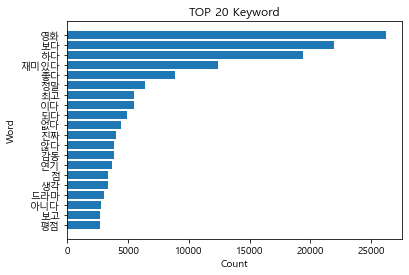

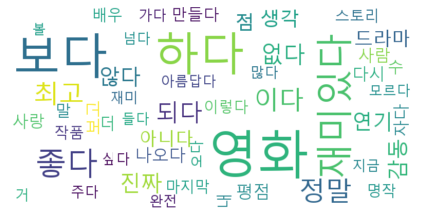

2. negative_word
[('감독', 2827), ('정말', 3267), ('좋다', 3286), ('뭐', 3318), ('쓰레기', 3358), ('재미없다', 3407), ('스토리', 3485), ('평점', 3640), ('나오다', 3825), ('않다', 3866), ('되다', 4016), ('아깝다', 4231), ('만들다', 4304), ('진짜', 4338), ('점', 4576), ('아니다', 5005), ('없다', 11175), ('보다', 16624), ('하다', 21856), ('영화', 24659)]


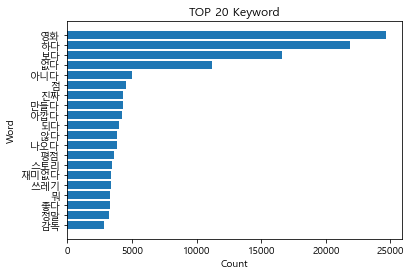

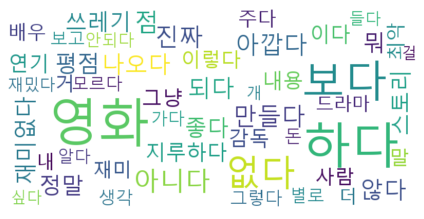

In [74]:
print('1. positive_word')
word_graph(pos_count, max_words=20)
word_cloud(pos_count)

print('2. negative_word')
word_graph(neg_count, max_words=20)
word_cloud(neg_count)

- 단어 빈도 그래프 및 워드 클라우드 생성 결과를 보고 삭제할 토큰을 불용어 사전에 추가하고 다시 시각화할 수 있음

### 4. 문서단어행렬(DTM) 도출
문서단어행렬 도출할 때 특성 집합 기준을 학습 데이터셋으로 할지, 학습/테스트 전체 데이터셋으로 할지 결정  
본 예제코드에서는 끝까지 학습 데이터셋을 기준으로 진행 

In [ ]:
# 학습/테스트 전체 데이터셋으로 한다면 앞의 처리 과정을 테스트 데이터셋에도 적용한 후 아래와 같이 데이터프레임 합하기

# review_all = pd.concat([train_review, test_review], ignore_index=True)
# review_all.head()

#### 4.1 Count 문서단어행렬 - CountVectorizer 사용

In [75]:
# 토큰 빈도수 세고, matrix 형태로 만들어주기, 이때 정의한 토크나이저 사용
cv = CountVectorizer(tokenizer=my_tokenizer, stop_words = stopwords, max_features=500)
dtm = cv.fit_transform(train_review['document']) # dtm 완성

# 맞춤법 교정한 리뷰로 하려면 아래와 같이
# dtm = cv.fit_transform(train_review['document_sp_checked']) # dtm 완성

In [76]:
dtm

<149946x500 sparse matrix of type '<class 'numpy.int64'>'
	with 723467 stored elements in Compressed Sparse Row format>

In [77]:
dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

- 문서단어행렬 내 열정보 확인

In [84]:
print(dtm.sum(axis=0).shape)
print(dtm.sum(axis=0).flat[:5])

# DataFrame 형태로 만들어주기
token_count=pd.DataFrame({
    'word': cv.get_feature_names(),
    'counts': dtm.sum(axis=0).flat
})

(1, 500)
[[3413  361 1331 1399  939]]


In [93]:
# check!
x = np.array([
    [ 1,  2,  3,  4],
    [ 5,  6,  7,  8],
    [ 9, 10, 11, 12],
])

print(np.sum(x, axis=0))
print(np.sum(x, axis=1))

print(x.sum(axis=0))

x_flatten = x.flatten()
print(x_flatten)
print(x_flatten[6])

print(x[1,2])
print(x.flat[6])

dtm_ar=dtm.toarray()
print(np.sum(dtm_ar, axis=0).shape)

[15 18 21 24]
[10 26 42]
[15 18 21 24]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
7
7
7
(500,)


In [86]:
token_count.sort_values('counts', ascending = False).head(10)

,word,counts
320,영화,50889
480,하다,41233
202,보다,38586
308,없다,15639
412,좋다,12157
388,재밌다,10415
403,정말,9660
125,되다,8899
435,진짜,8360
352,이다,8290


#### 4.2 Tf-Idf 문서단어행렬 - TfidfVectorizer 사용
카운트 벡터로부터 변환하는 TfidfTransformer 클래스 대신 텍스트로부터 바로 Tf-Idf 문서단어행렬을 만들어주는 TfidfVectorizer 클래스 사용 

In [87]:
tfidf = TfidfVectorizer(tokenizer=my_tokenizer, stop_words = stopwords, max_features=500)
# norm='l2' : 문서 벡터 원소의 제곱합이 1이 되도록 정규화하는 것이  디폴트 => 두 벡터간 코사인 유사도는 두 벡터의 내적과 같음

dtm_tfidf = tfidf.fit_transform(train_review['document'])

# 맞춤법 교정한 리뷰로 하려면 아래와 같이
# dtm_tfidf = tfidf.fit_transform(train_review['document_sp_checked'])

In [94]:
dtm_tfidf

<149946x500 sparse matrix of type '<class 'numpy.float64'>'
	with 723467 stored elements in Compressed Sparse Row format>

In [95]:
dtm_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.46031382, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

- 문서 단어 행렬 내 열정보 확인

In [96]:
# DataFrame 형태로 만들어주기
token_tfidf = pd.DataFrame({
    'word': tfidf.get_feature_names(),
    'counts': dtm_tfidf.sum(axis=0).flat
})

In [97]:
token_tfidf.sort_values('counts', ascending = False).head(10)

,word,counts
320,영화,10555.698818
202,보다,8357.026226
480,하다,8294.357075
308,없다,4372.651099
388,재밌다,4369.894536
412,좋다,3975.017558
403,정말,3100.530475
398,점,2782.882246
435,진짜,2756.461605
352,이다,2619.110271
